data info is here
[info](http://www.census.gov/econ/cbp/download/noise_layout/ZIP_Totals_Layout10.txt)

In [32]:
%matplotlib inline

import pylab as plt
import pandas as pd
import numpy as np
import geopandas as gp

import os

from palettable.wesanderson import Zissou_5

# import sklearn.cluster
from scipy.cluster.vq import kmeans2
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

import zipfile #i am not giving it a name cause i intend to use it only once
PWD = os.getenv('PWD')

## Getting and cleaning the data

In [2]:
def getFiles(folder, format, full=True):
    for file in os.listdir(folder):
        if file.endswith(format):
            if full:
                yield os.path.join(folder, file)
            else:
                yield file

In [3]:
# datas = [pd.read_csv(x) for x in getFiles(PWD + '/data/zbp/', '.zip')]

datas = []

for x in getFiles(PWD + '/data/zbp/', '.zip'):
    zf = zipfile.ZipFile(x)
    df = pd.read_csv(zf.open(zf.infolist()[0]))
    df.columns = df.columns.str.lower()
    y = int(x.split('/')[-1][3:5])
    if y > 60: 
        y = 1900 + y
    else:
        y = 2000 + y
    df['year'] = y
    datas.append(df)

In [4]:
df = pd.concat(datas)

In [5]:
df.head()

,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,660,NaN,NaN,NaN,40,NaN,NaN,11,"HOLTSVILLE, NY",148,NaN,NaN,2002,501
1,0,NaN,NaN,NaN,0,NaN,I,490,"AGAWAM, MA",0,NaN,NaN,2002,1001
2,170725,NaN,NaN,NaN,6866,NaN,NaN,566,"AMHERST, MA",39616,NaN,NaN,2002,1002
3,3900,NaN,NaN,NaN,268,NaN,NaN,15,"AMHERST, MA",1097,NaN,NaN,2002,1003
4,4032,NaN,NaN,NaN,169,NaN,NaN,23,"AMHERST, MA",1015,NaN,NaN,2002,1004


In [6]:
dfc = df[['name','qp1','emp','zip','year']]

In [7]:
ts1 = df[['zip', 'year', 'est']].groupby(['zip', 'year']).sum().unstack().T #.reset_index().set_index('year').drop('est').T
ts1.fillna(0, inplace=1)
ts1.index = ts1.index.get_level_values(1) ## remove multiindexing
ts1.index = pd.to_datetime(ts1.index, format='%Y')
ts1.head()

/Users/casy/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


zip,501,1000,1001,1002,1003,1004,1005,1007,1008,1009,...,99921,99922,99923,99925,99926,99927,99928,99929,99950,99999
year,,,,,,,,,,,,,,,,,,,,,
1994-01-01,0,0,439,450,10,47,92,182,18,14,...,53,6,6,24,13,3,21,100,7,11580
1995-01-01,2,4,439,467,10,48,95,172,19,16,...,55,6,5,25,9,4,21,98,5,12569
1996-01-01,4,11,433,487,13,47,101,183,14,15,...,66,7,6,30,13,3,17,101,7,22996
1997-01-01,4,8,457,500,15,41,104,183,17,18,...,69,7,7,26,17,2,12,104,10,3504
1998-01-01,3,0,444,490,14,31,95,183,18,17,...,70,6,7,27,17,2,8,103,10,20232


### Zipcodes

In [8]:
zips = gp.read_file(PWD + '/data/zipcodes/nyc-zip-codes.geojson')

In [9]:
zips.head(2)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.8744,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.9139,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004


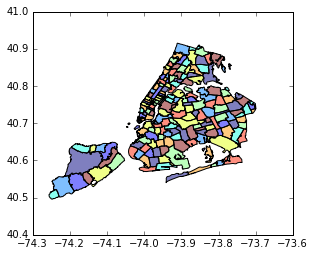

In [10]:
zips.plot()

In [11]:
zips.postalCode = zips.postalCode.astype(int)

In [12]:
# filtering 

In [13]:
tsNYC = ts1[[col for col in ts1.columns.tolist() if col in zips.postalCode.tolist()]]

## Normalising TS

In [14]:
tsNYC.head()

zip,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
year,,,,,,,,,,,,,,,,,,,,,
1994-01-01,6999,1784,3256,1115,1076,1061,1307,634,3019,3301,...,226,760,586,51,2,401,66,95,294,33
1995-01-01,7088,1819,3377,1124,1109,1002,1274,633,2987,3340,...,240,768,598,50,2,394,67,90,285,32
1996-01-01,7075,1919,3417,1133,1216,969,1254,673,3029,3392,...,241,777,596,53,2,406,71,88,287,34
1997-01-01,7154,2049,3535,1173,1227,990,1287,747,3112,3541,...,252,817,599,51,3,399,73,83,294,38
1998-01-01,7254,2003,3649,1176,1270,1030,1282,786,3152,3599,...,269,800,634,51,3,387,69,79,291,38


In [15]:
tsNorm = tsNYC
tsNorm = (tsNorm - tsNorm.mean())/tsNorm.std()

In [16]:
tsNorm.head()

zip,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
year,,,,,,,,,,,,,,,,,,,,,
1994-01-01,-1.703900,-1.608752,-1.814413,-1.502790,-2.661929,1.795465,-0.460537,-1.658178,-0.408503,-2.075578,...,-2.101315,-1.608015,-1.431208,-1.334879,-0.999919,-0.928218,-0.871675,-0.512400,-0.869053,-1.485187
1995-01-01,-1.089806,-1.524391,-1.424651,-1.424029,-2.114617,1.079437,-0.724082,-1.663583,-0.938453,-1.871595,...,-1.569657,-1.488964,-1.309163,-1.387920,-0.999919,-1.109263,-0.778834,-0.771479,-1.394376,-1.648196
1996-01-01,-1.179505,-1.283359,-1.295805,-1.345267,-0.339997,0.678946,-0.883806,-1.447378,-0.242894,-1.599616,...,-1.531682,-1.355032,-1.329504,-1.228796,-0.999919,-0.798899,-0.407469,-0.875110,-1.277637,-1.322179
1997-01-01,-0.634410,-0.970018,-0.915707,-0.995216,-0.157560,0.933804,-0.620261,-1.047397,1.131663,-0.820294,...,-1.113950,-0.759777,-1.298992,-1.334879,-0.052627,-0.979945,-0.221787,-1.134189,-0.869053,-0.670145
1998-01-01,0.055583,-1.080893,-0.548493,-0.968962,0.555605,1.419247,-0.660192,-0.836596,1.794101,-0.516933,...,-0.468365,-1.012760,-0.943027,-1.334879,-0.052627,-1.290309,-0.593152,-1.341452,-1.044160,-0.670145


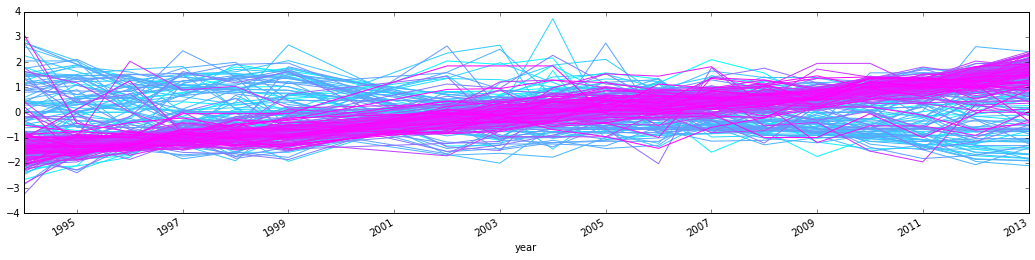

In [17]:
tsNorm.plot(figsize=(18,4), legend=0, cmap='cool');

## K-mean Clustering

In [18]:
def clusterAndPlot(df,k, width=18):
    '''calculate and plot kmean clustering'''
    centroids, label = kmeans2(df, k, iter=10, thresh=1e-05)
    df['label'] = label
    fig, axes = plt.subplots(k+1, figsize=(18,width), sharex='all')
    
    #one by one
    for l, g in df.groupby('label'):
        g.T.plot(ax=axes[l], legend=0, c='k',alpha=.1)
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
    # centroids
    for i, c in enumerate(centroids):
        pd.Series(c).plot(ax=axes[-1], label='cluster %d'% (i ))
    
    plt.legend()
    return df['label']


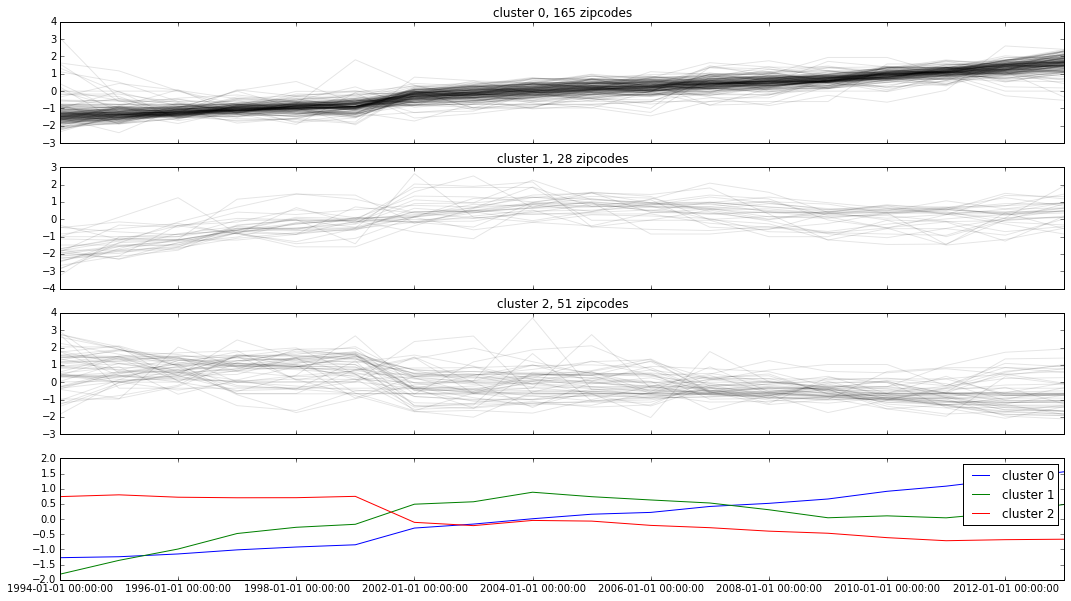

In [19]:
#lets do 3 clusters first

dummy = clusterAndPlot(tsNorm.T,3, width=10)


### Interesting! let's try more clusters now

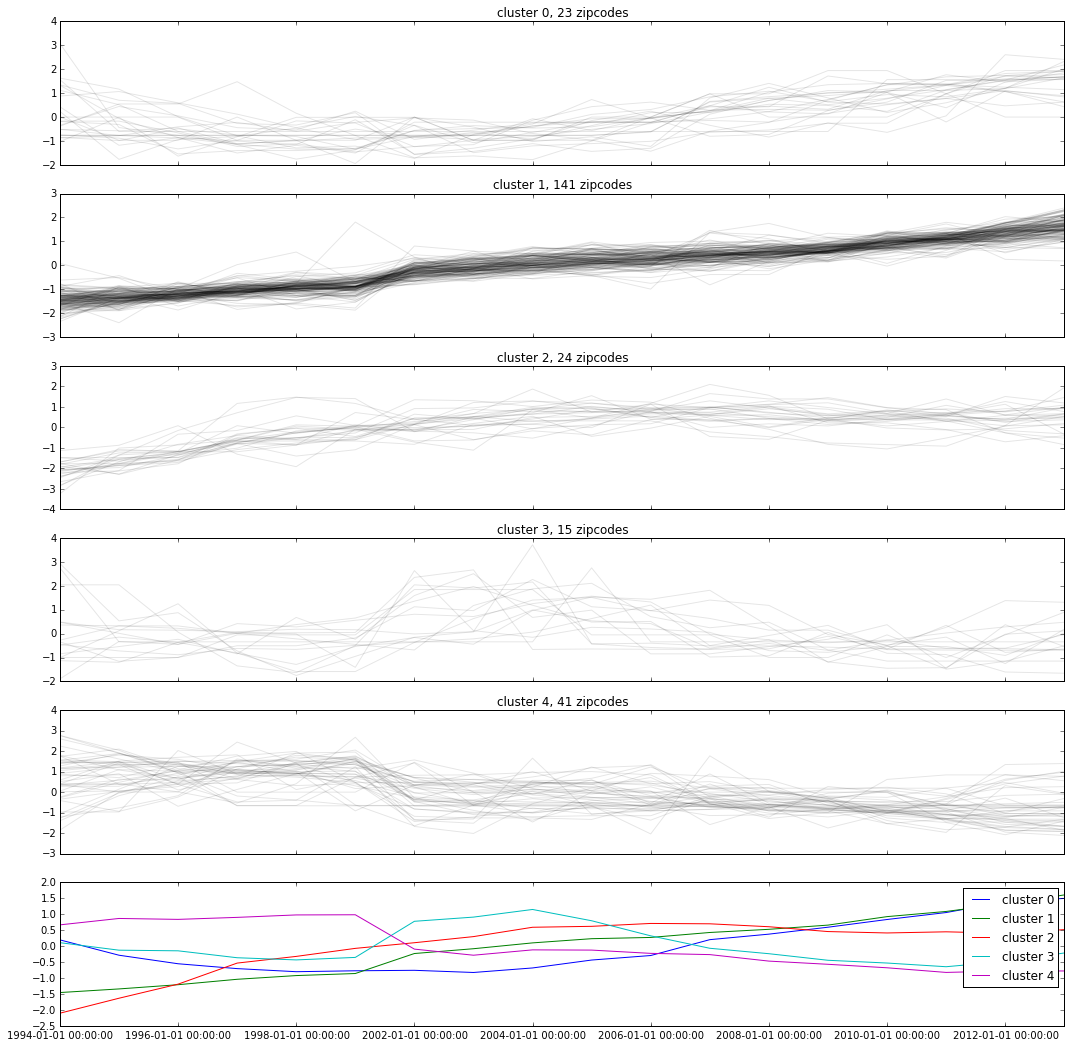

In [28]:
km_labels = clusterAndPlot(tsNorm.T,5, width=18)
km_labels +=1

## Hierarchical Clustering

In [21]:
def hierarchical(df, truncate = False, ps=12):
    Z = linkage(df, 'ward')
    
    c, coph_dists = cophenet(Z, pdist(df))
    print c
    
    labels = fcluster(Z, ps, criterion='maxclust')
    
#     All clusters
    if truncate:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        
        dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=ps,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
        )
        plt.show()
        
    else:
        plt.figure(figsize=(25, 10))
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendrogram( Z,
        leaf_rotation=0.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        )
        plt.show()


0.882994473792


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


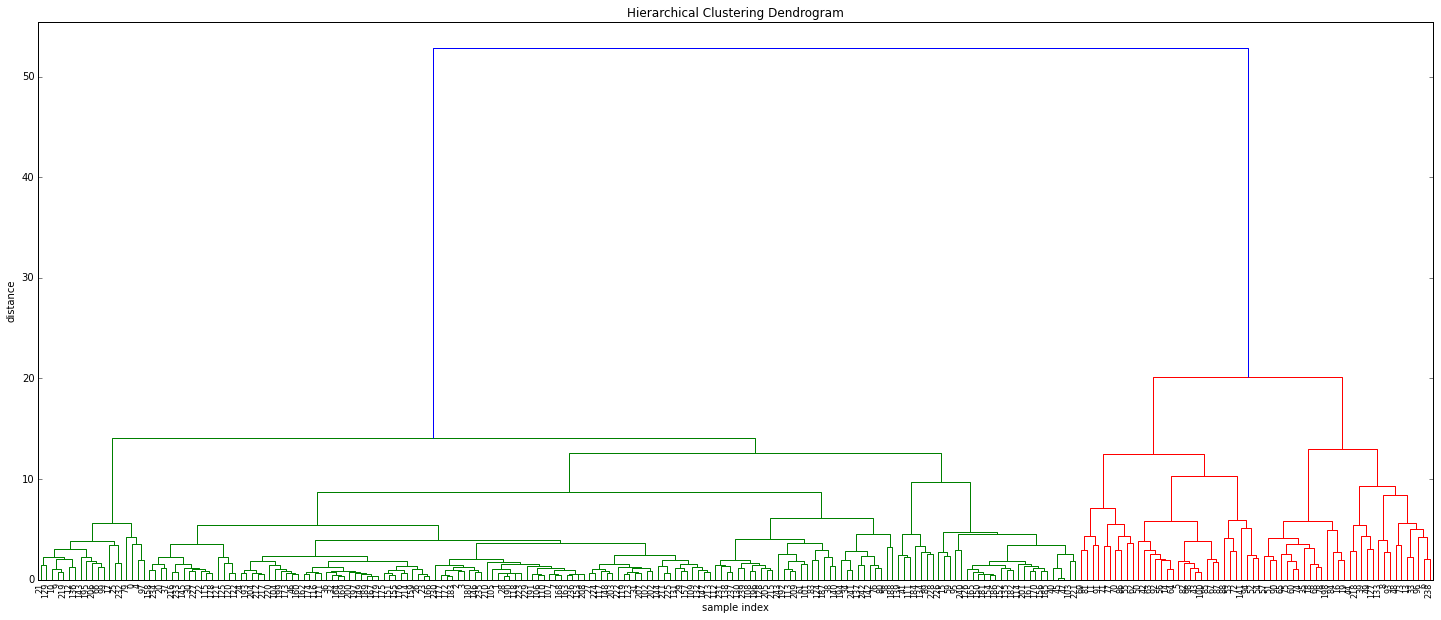

In [22]:
hierarchical(tsNorm.T, truncate= False, ps=20)

It looks like (at least with this  distance calculation method) thath there are 2 main patterns here

0.882994473792


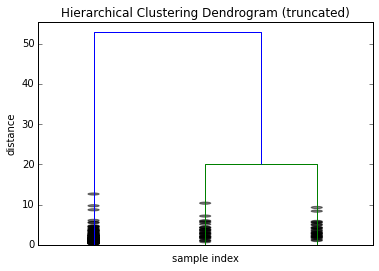

In [27]:
## let's check truncated tree now

hierarchical(tsNorm.T, truncate= True, ps=3)

In [24]:
def plotClusters(df, n=3,  width=18):
    '''calculate and plot kmean clustering'''
    Z = linkage(df, 'ward')
    labels = fcluster(Z, n, criterion='maxclust')
    df['label'] = labels
    fig, axes = plt.subplots(n, figsize=(18,width), sharex='all')

    #one by one
    for l, g in df.groupby('label'):
#         print l, g.columns
        g.drop('label', axis=1).T.plot(ax=axes[l-1], legend=0, c='k',alpha=.1)
        axes[l-1].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
    return df['label']
        

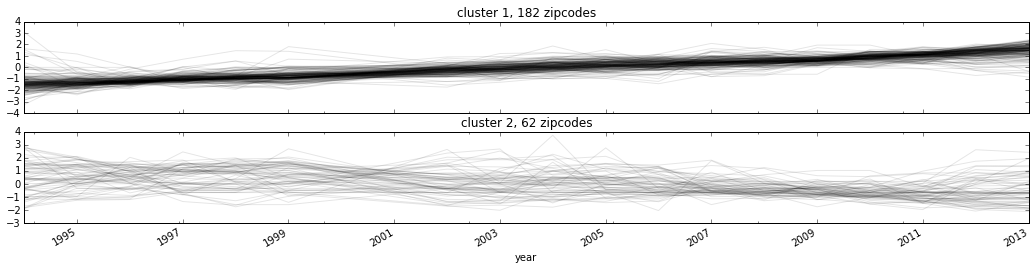

In [25]:
dummy = plotClusters(tsNorm.T, n=2, width=4)

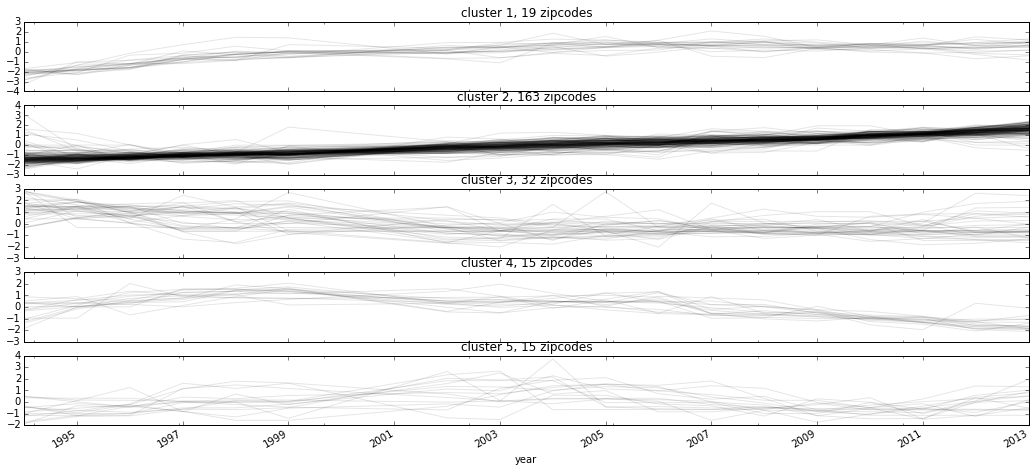

In [26]:
dendo_labels = plotClusters(tsNorm.T, n=5, width=8)

while there are two major trends (clusters) in this data - growing and stagnation, they can be detailed down to 5 specific scenarios: 

- constant growth (most of the zipcodes, cluster 2)
- growth in the end of 90-th and  slowering down after (cluster 1)
- shrinking of businesses in the end of 90-th and stabilisation after (cluster 3)
- growing in the end of 90-th and decreasing after cluster 4
- stable situation with some dynamics (both way) in 2003-2004

## Plotting

Lets now plot everything on map

In [33]:
labls = pd.DataFrame({'dlabels': pd.Series(dendo_labels), 'klabels': pd.Series(km_labels)})

nycmap = zips.rename(columns={'postalCode':'zip'}).set_index('zip')
nycmap2 = nycmap.merge(labls, how='right', left_index=1, right_index=1)

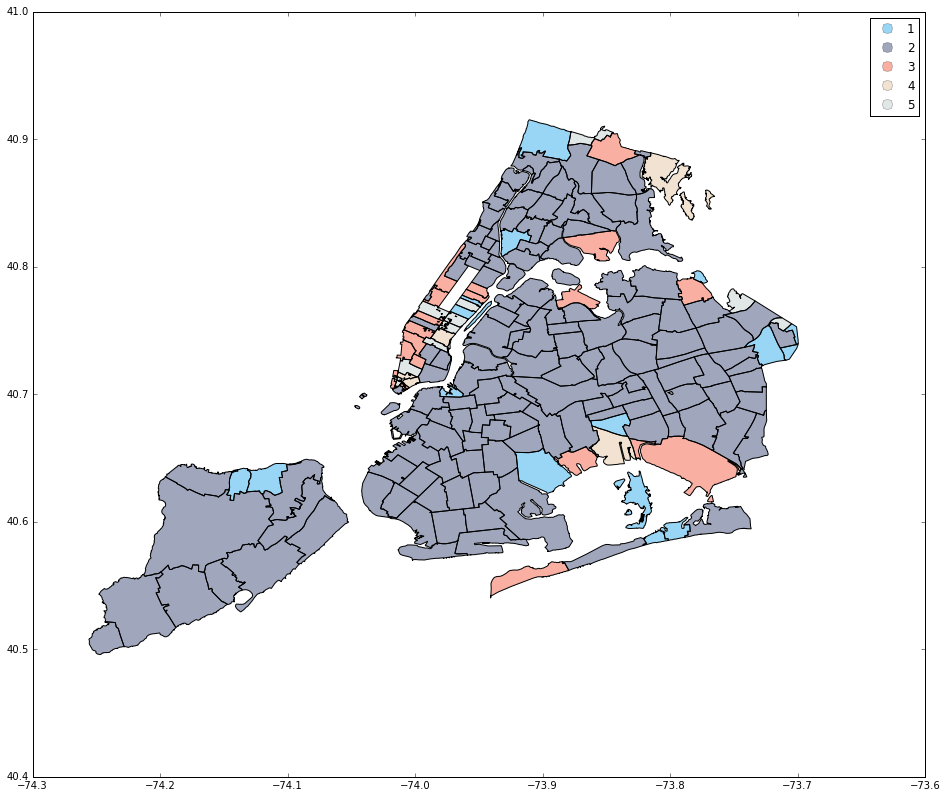

In [37]:

nycmap2.plot(column='klabels', figsize=(16,16), categorical=True, legend=True, colormap = Zissou_5.mpl_colormap, alpha=.4)

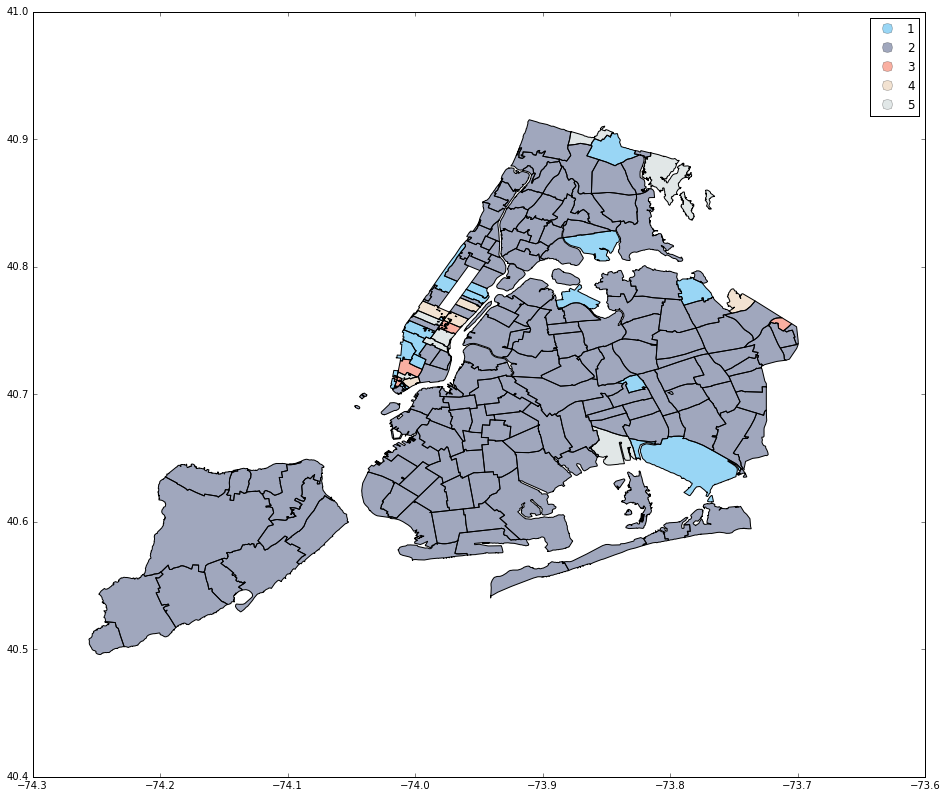

In [38]:
nycmap2.plot(column='dlabels', figsize=(16,16), categorical=True, legend=True, colormap = Zissou_5.mpl_colormap, alpha=.4)

### Comparing results 

Both of approaches gave more or less similar results for 5 clusters: whyle most of areas have constant growth over the time, some neighborhoods have different labels (grouped to different trands), some are grouped as "growing" or "stagnating" depending on approach, for example, in Breezy Point.

## Interpretation

First, we see that bysinesses are increasing in most of the boroghs. However, lerge part of the manhattan, according to both clustering algorythms, does not grow over the time - it probably reached it's capacity limit. Most of all other clusters sits on the borders on the city, representing either shrinking onse or the ones who have too few businesses so they have large overal noise.